# Multi physics HFSS-Icepak microwave oven simulation
This example shows how to couple together HFSS and Icepak to
run multi physics analysis on a well-know problem of microwave oven.

Keywords: **HFSS**, **modal**, **microwave oven**, **Icepak**, **Multi physics**.


<img src="_static/oven.png" width="500">

## Prerequisites

### Perform imports

In [1]:
import ansys.aedt.core
import os
import time
import tempfile
import pyvista
import numpy as np
from ansys.aedt.core import generate_unique_name
from ansys.aedt.core.visualization.plot.pdf import AnsysReport

### Define constants.

Constants help ensure consistency and avoid repetition throughout the example.

In [2]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

### Create temporary directory

Create a temporary working directory.
The name of the working folder is stored in ``working_dir.name``.

In [3]:
working_dir = tempfile.TemporaryDirectory(suffix=".ansys")

### Download the project
Download and open the project. Save it to the temporary working folder.

In [4]:
parasolid_path = ansys.aedt.core.downloads.download_file(
   source="oven", name="gingerbread.x_t", destination=working_dir.name
)
oven_path = ansys.aedt.core.downloads.download_file(
   source="oven", name="microwave_oven.aedt", destination=working_dir.name
)

### Launch HFSS
Open AEDT and initialize the microwave oven project.

After the project is opened, we save it in our working directory.

In [5]:
hfss = ansys.aedt.core.Hfss(version=AEDT_VERSION, 
                            project=oven_path, 
                            non_graphical=NG_MODE, 
                            new_desktop=True)
hfss.save_project(file_name=os.path.join(working_dir.name,'lets_cook.aedt'))

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpn6f9xr_x.ansys\oven\microwave_oven.aedt.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.15.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_1e3c4ee7-faae-420c-9246-3631c4f38669.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 63704.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpn6f9xr_x.ansys\oven\microwave_oven.aedt correctly loaded. Elapsed time: 0m 1sec


PyAEDT WARNING: Electronics Desktop license not found on the default license server.


PyAEDT INFO: Electronics Desktop started on gRPC port: 63704 after 1.5470895767211914 seconds.


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 1904.


PyAEDT INFO: Project microwave_oven has been opened.


PyAEDT INFO: Active Design set to microwave


PyAEDT INFO: Active Design set to microwave


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Project lets_cook Saved correctly


True

## Model Preparation

### Assign material
This phase is fundamental because we need to assign correct material properties that are valid for both electrical and thermal analysis.

PyAEDT simplifies the creation and modification of a material 
definitions using _getter_ and _setter_ methods. In this example we modify 5 material parameters.

In [6]:
ginger_material = hfss.materials.add_material(name="ginger_bread")
ginger_material.permittivity = 41
ginger_material.dielectric_loss_tangent = 0.32
ginger_material.thermal_conductivity = 0.38
ginger_material.mass_density = 1831
ginger_material.specific_heat = 3520

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Adding new material to the Project Library: ginger_bread


PyAEDT INFO: Material has been added in Desktop.


### Import the gingerbread man and assign material
Once the object is imported all of its properties can be edited. 
We are gonna move the gingerbread at the center of the plate and assign material to it.

Finally, we are gonna change the transparency of the glass bowl.

In [7]:
hfss.modeler.import_3d_cad(input_file=parasolid_path)
ginger_bread = hfss.modeler["plateauPainEpices_Unnamed_5"]
hfss.modeler.move(assignment=ginger_bread, vector=["-0.5in", "-0.2in","-38.1mm"])
ginger_bread.material_name=ginger_material.name
hfss.modeler["glassBowl"].transparency = 0.75

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Step file C:\Users\ansys\AppData\Local\Temp\tmpn6f9xr_x.ansys\oven\gingerbread.x_t imported


### Export an image
At the end of this example we will generate a PDF report that summarizes the workflow and simulation results.

We now save an image of the model as a PNG file to insert into the report later.

In [8]:
hfss.post.export_model_picture(full_name=os.path.join(working_dir.name,'ginger_bread_cookie.png'))

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpn6f9xr_x.ansys/lets_cook.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpn6f9xr_x.ansys/lets_cook.aedt correctly loaded. Elapsed time: 0m 1sec


PyAEDT INFO: aedt file load time 0.8469932079315186


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 1sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 1sec


'C:\\Users\\ansys\\AppData\\Local\\Temp\\tmpn6f9xr_x.ansys\\ginger_bread_cookie.png'

### Launch Icepak
In order to run a multiphysics analysis we need to create an Icepak project that will be retrieve the loss data from HFSS to use as a heat source.

In [9]:
ipk = ansys.aedt.core.Icepak(solution_type="Transient Thermal")
ipk.copy_solid_bodies_from(design=hfss, no_vacuum=False, no_pec=False, include_sheets=True)
ipk.modeler["Region"].delete()
ipk.modeler.fit_all()
exc = ipk.assign_em_losses(
    design=hfss.design_name,
    setup=hfss.setups[0].name,
    sweep="LastAdaptive",
    map_frequency=hfss.setups[0].props["Frequency"],
    surface_objects=[],
    assignment=["glassBowl", ginger_bread.name]
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.15.dev0.


PyAEDT INFO: Returning found Desktop session with PID 1904!


PyAEDT INFO: No project is defined. Project lets_cook exists and has been read.


PyAEDT INFO: No consistent unique design is present. Inserting a new design.


PyAEDT INFO: Added design 'Icepak_3ZX' of type Icepak.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Mapping EM losses.


PyAEDT INFO: Boundary EMLoss EMLoss_WFZ2GE has been created.


### Thermal boundaries
Main thermal boundaries will be free opening of the microwave oven. 

In this example we set 2 different types of openings on the two faces of the oven.

In [10]:
ipk.modeler["ovenCavity"].transparency = 1
ipk.assign_free_opening(assignment=ipk.modeler["ovenCavity"].top_face_y.id,
                        flow_type="Velocity",
                        velocity=["0m_per_sec", "-0.5m_per_sec", "0m_per_sec"])
ipk.assign_free_opening(assignment=ipk.modeler["ovenCavity"].bottom_face_y.id,
                        flow_type="Pressure")

PyAEDT INFO: Boundary Opening Opening_T7U085 has been created.


PyAEDT INFO: Boundary Opening Opening_GDCQ5P has been created.


#### Icepak multiple reference frame (MRF)
The MRF assumes mesh rotation as a solid block. In this example is useful to rotate the oven plate and cookie to reduce cooking time.

In [11]:
rot_cyl= ipk.modeler.create_cylinder(orientation="Z",
                                     origin=[158.75 ,228.6 ,0],
                                     radius=110, height=150,
                                     material="air",
                                     name="rotating_cylinder")
rot_cyl.display_wireframe=True
rot_cyl.transparency = 1
block = ipk.assign_solid_block(rot_cyl.name,0)
block.props["Use MRF"]=True
block.props["MRF"]="6rpm"
block.props["Is Cylinder MRF"]=True

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Boundary Block Block_V5Q98D has been created.


### Icepak mesh settings
Icepak mesh settings are used to optimize the simulation time and accuracy. 

In [12]:
ipk.mesh.global_mesh_region.manual_settings = True
ipk.mesh.global_mesh_region.settings["MaxElementSizeX"] = "15mm"
ipk.mesh.global_mesh_region.settings["MaxElementSizeY"] = "15mm"
ipk.mesh.global_mesh_region.settings["MaxElementSizeZ"] = "15mm"
ipk.mesh.global_mesh_region.settings["BufferLayers"]='2'
ipk.mesh.global_mesh_region.settings["MaxLevels"]='2'
ipk.mesh.global_mesh_region.update()

PyAEDT WARNING: No mesh operation found.


PyAEDT WARNING: No mesh region found.


PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec


True

### Icepak solution setup
In this example we are limiting the number of steps to a maximum of 5 steps to make the example quick to run. Ideally this number has to be increased to improve the simulation accuracy and obtain more precise results.

In [13]:
setup = ipk.create_setup()
setup.props["SaveFieldsType"] = "Every N Steps"
setup.props["N Steps"] = "5"
setup.props["Turbulent Model Eqn"] = "kOmegaSST"
setup.props["Flow Regime"] = "Turbulent"
solved = False
stop_time = 0

### Icepak report preparation

In [14]:
ipk.save_project()
ginger_bread_thermal = ipk.modeler["plateauPainEpices_Unnamed_5"]
ginger_bread_thermal.transparency = 1
objects = ipk.modeler.non_model_objects[::] + ["glassBowl"]

microwave_objects = ipk.post.export_model_obj(objects, export_as_multiple_objects=True, )

PyAEDT INFO: Project lets_cook Saved correctly


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpn6f9xr_x.ansys/lets_cook.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpn6f9xr_x.ansys/lets_cook.aedt correctly loaded. Elapsed time: 0m 2sec


PyAEDT INFO: aedt file load time 1.864133358001709


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 2sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 2sec


### Initialize Ansys report

``AnsysReport`` PyAEDT class that allows creation of
simple and effective PDF reports
that include text, images, tables and charts.

In [15]:
report = AnsysReport(
        version=ipk.aedt_version_id, design_name=ipk.design_name, project_name=ipk.project_name
    )
report.create()
report.add_section()
report.add_chapter(f"Ansys GingerBread Recipe")
report.add_sub_chapter("Ingredients")

report.add_text("Step 1: Melt the sugar, golden syrup and butter in a saucepan, then bubble for 1-2 mins.")
report.add_text("Leave to cool for about 10 mins.")

report.add_text("Step 2: Tip the flour, baking soda and spices into a large bowl.")
report.add_text("Add the warm syrup mixture and the egg, stir everything together, then gently knead in the bowl until smooth and streak-free.")
report.add_text("The dough will firm up once cooled. Wrap in cling film and chill for at least 30 mins.")

report.add_text("Step 3: Remove the dough from the fridge, leave at room temperature until softened. ")
report.add_text("Set the microwave oven power to 1200W but be careful about the time!!!")
report.add_page_break()
report.add_sub_chapter("Design the Microwave Oven... with HFSS")
report.add_text("An accurate Microwave Oven design requires:")
report.add_text("1- Ansys HFSS")
report.add_text("2- PyAEDT")

report.add_image(path=os.path.join(working_dir.name,'ginger_bread_cookie.png'),
                 caption="HFSS Design of Ansys Microwave Oven")

report.add_page_break()
report.add_sub_chapter("Determine cooking time... with Icepak")
report.add_text("")
report.add_text("")
report.add_text("A complete Icepak project requires:")
report.add_text("1- Correct material assignment")
report.add_text("2- Rotating gingerbread")
report.add_text("3- Convection settings")
report.add_text("4- Accurate EM Losses from HFSS")
report.add_page_break()
report.add_sub_chapter("Recipe experiments")

True

### Compute average temperature of the cookie
The following set of commands show how to use Icepak field summary to
compute the temperature on the gingerbread biscuit and get the mean value of it.

In [16]:
def get_average_temperature():
    fs = ipk.post.create_field_summary()
    fs.add_calculation(entity="Object",
                       geometry="Surface",
                       geometry_name=ginger_bread_thermal.name,
                       quantity="Temperature",
                       time=f"{stop_time}s")
    df = fs.get_field_summary_data(pandas_output=True)
    return float(df["Mean"])

### Method to generate streamline plot on gingerbread cookie
This method encapsulate a set of action to plot and arrange the view of
the gingerbread inside the microwave oven with velocity streamline plot.
The view is set to front $(y-z)$.

In [17]:
def generate_streamline(stop):
    def generate_case(quantity_in, field_time, assignment=["ovenCavity", "rotating_cylinder"]):
        f1 = ipk.post.create_fieldplot_volume(assignment=assignment,
                                              quantity=quantity_in,
                                              intrinsics={"Time": f"{field_time}s"})
        air_ux_case = ipk.post.export_field_plot(plot_name=f1.name,
                                                 output_dir=working_dir.name,
                                                 file_format="case")
        mesh_in = pyvista.read(air_ux_case)
        return mesh_in

    mesh_ux = generate_case(quantity_in="Ux", field_time=stop)
    mesh_uy = generate_case(quantity_in="Uy", field_time=stop)
    mesh_uz = generate_case(quantity_in="Uz", field_time=stop)
    mesh_temp = generate_case(quantity_in="Temperature", field_time=stop)
    mesh_ginger = generate_case(assignment=["plateauPainEpices_Unnamed_5"],
                                quantity_in="Temperature",
                                field_time=stop)

    temp_block = mesh_temp[0]  # First block for temperature
    # Extract the actual mesh (assuming it's the first block in MultiBlock)
    ux_block = mesh_ux[0]  # First block
    uy_block = mesh_uy[0]  # First block
    uz_block = mesh_uz[0]  # First block
    ux = ux_block.point_data.values()[0]
    uy = uy_block.point_data.values()[0]
    uz = uz_block.point_data.values()[0]
    temperature = temp_block.point_data.values()[0]  # Temperature data
    velocity = np.column_stack((ux, uy, uz))
    ux_block.point_data["Velocity"] = velocity
    ux_block.point_data["Temperature"] = temperature
    seed = pyvista.Box(bounds=(50, 260, 0, 500, -1, 150), level=10)
    streamlines = ux_block.streamlines_from_source(
        seed, max_time=200.0, integration_direction="both"
    )

    pl = pyvista.Plotter(off_screen=True, window_size=(3840, 2160))
    for filename, color, opacity in microwave_objects:
        reader = pyvista.get_reader(filename)
        mesh = reader.read()
        pl.add_mesh(
            mesh,
            smooth_shading=True,
            split_sharp_edges=True,
            color=color,
            opacity=opacity,
            ambient=0.05,
        )

    pl.add_mesh(streamlines, line_width=4, scalars="Temperature", cmap="coolwarm")
    pl.add_mesh(mesh_ginger)
    pl.enable_ssao(kernel_size=128, radius=15, bias=0.5)
    pl.enable_anti_aliasing("ssaa")
    pl.camera_position = "yz"
    pl.camera.elevation += 20
    pl.enable_ssao(kernel_size=128, radius=15, bias=0.5)
    pl.enable_anti_aliasing("ssaa")
    pl.screenshot(os.path.join(working_dir.name, "streamlines.png"))
    return os.path.join(working_dir.name, "streamlines.png")

### Method to generate temperature plot on gingerbread
This method encapsulates a set of actions to plot and arrange the view of
the gingerbread inside the microwave oven. The view is set to front $(y-z)$.

In [18]:
def generate_temps(stop):
    pl = ipk.post.plot_field(
        quantity="Temperature",
        assignment=ginger_bread_thermal.faces,
        plot_cad_objs=True,
        show=False,
        intrinsics={"Time": f"{stop}s"},
        scale_min=22,
        scale_max=110,
        show_legend=False,
        dark_mode=False,
    )
    for mw_obj in microwave_objects:
        pl.add_object(mw_obj[0], mw_obj[1], mw_obj[2])
    pl.camera_position = 'yz'
    pl.elevation_angle = 20
    pl.plot(export_image_path=os.path.join(working_dir.name, f'{generate_unique_name("Temperature")}.jpg'),
               show=False)
    return pl

## Cook the gingerbread
### Loop to determine transient time
This is the core of our optimization process. We increase the Icepak stop time by steps of 5 seconds until the mean temperature of the gingerbread reaches the 50 degrees. We could also have used an optimizer (Optislang) or run a longer time and plot the average temperature over time.

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Icepak correctly changed.


PyAEDT INFO: Solving design setup Setup


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Icepak correctly changed.


PyAEDT INFO: Design setup Setup solved correctly in 0.0h 5.0m 37.0s


PyAEDT INFO: Mean Temperature in the Gingerbread is 31.6073 after 5s in the microwave


PyAEDT INFO: Active Design set to Icepak_3ZX


PyAEDT INFO: Active Design set to Icepak_3ZX


PyAEDT INFO: Active Design set to Icepak_3ZX


PyAEDT INFO: Active Design set to Icepak_3ZX


PyAEDT INFO: Active Design set to Icepak_3ZX


PyAEDT INFO: Project lets_cook Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Icepak correctly changed.


PyAEDT INFO: Solving design setup Setup


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Icepak correctly changed.


PyAEDT INFO: Design setup Setup solved correctly in 0.0h 2.0m 41.0s


PyAEDT INFO: Mean Temperature in the Gingerbread is 43.4325 after 10s in the microwave


PyAEDT INFO: Active Design set to Icepak_3ZX


PyAEDT INFO: Active Design set to Icepak_3ZX


PyAEDT INFO: Active Design set to Icepak_3ZX


PyAEDT INFO: Active Design set to Icepak_3ZX


PyAEDT INFO: Active Design set to Icepak_3ZX


PyAEDT INFO: Project lets_cook Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Icepak correctly changed.


PyAEDT INFO: Solving design setup Setup


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Icepak correctly changed.


PyAEDT INFO: Design setup Setup solved correctly in 0.0h 2.0m 29.0s


PyAEDT INFO: Active Design set to Icepak_3ZX


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


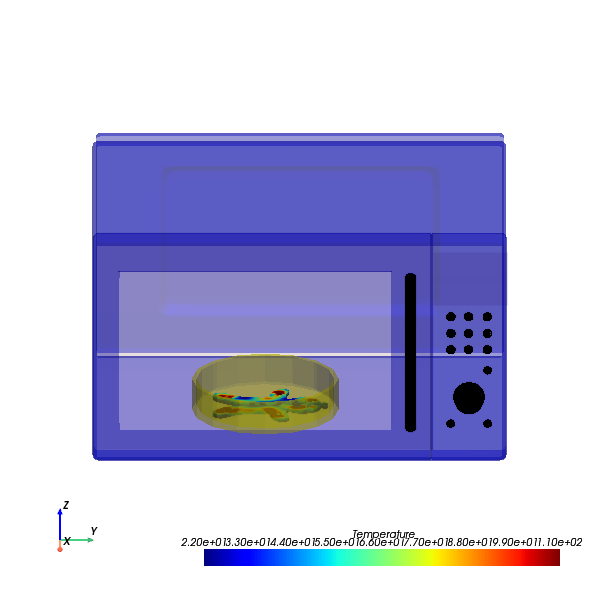

In [19]:
while not solved:
    stop_time = stop_time + 5
    setup.props["Stop Time"] = f"{stop_time}s"
    setup.analyze(cores=4, tasks=4)
    mean_temperature = get_average_temperature()
    if mean_temperature>50:
        solved = True
        report.add_page_break()
        report.add_sub_chapter(f"The Gingerbread is ready!!!!")
        report.add_text(f"The perfect time for cooking the Gingerbread is {stop_time}s")
        plot4 = generate_temps(stop_time)
        report.add_image(plot4.image_file, f"GingerBread at the end of cooking.")
    else:
        ipk.logger.info(f'Mean Temperature in the Gingerbread is {mean_temperature} after {stop_time}s in the microwave')
        if mean_temperature > 30:
            report.add_text(f"Gingerbread is almost ready. Don't worry we will notify you when ready.")
            output_file = generate_streamline(stop_time)
            report.add_image(os.path.join(working_dir.name, "streamlines.png"), f"GingerBread while cooking after {stop_time}s")
        else:
            report.add_text(f"Take a cup of tea and relax. It will take longer.")
        ipk.save_project()

### Generate PDF

In [20]:
report.add_toc()
report.save_pdf(working_dir.name, "Gingerbread_ansys_recipe.pdf")

'C:\\Users\\ansys\\AppData\\Local\\Temp\\tmpn6f9xr_x.ansys\\Gingerbread_ansys_recipe.pdf'

## Release AEDT

Release AEDT and close the example.

In [21]:
ipk.save_project()
ipk.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project lets_cook Saved correctly


PyAEDT INFO: Desktop has been released and closed.


### Clean up

All project files are saved in the folder ``temp_folder.name``. If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes all temporary files, including the project folder.

In [22]:
working_dir.cleanup()